# Tutorial 4: Classification using machine learning

#### Hello, and welcome to the final tutorial in this series!

This tutorial will show you how to:
 - Use different machine learning methods (logistic regression and random forest) tools to classify rooibos teas
 - Apply parameter optimization to improve the classifiers
 - Compare those methods against each other using jackknife and a baseline
 
 Can't wait to get started! First we download the necessary packages.

In [20]:
## Python packages 
from sklearn.linear_model import LogisticRegression # a ML method
from sklearn.ensemble import RandomForestClassifier # a ML method
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from source.calculate_jack import jack_SD # importing the baseline code from source.basline file

We also need the data stored in files `df` and `base_dict` which were created in Tutorial 3. 

In [21]:
%store -r df
%store -r base_dict 

### Set up machine learning methods and their hyper-parameters

Logistic regression and random forest are leading machine learning (ML) methods. We will apply both and compare the reuslts. First we create aliases for the two classifiers, and create a list to use when we apply the classifiers one by one.

In [22]:
lr = LogisticRegression() # defining the model
rf = RandomForestClassifier() # defining the model

## Define a list of models, We will use this when we loop through ML methods.
models = [ [lr, 'lr'], [rf, 'rf']]


ML methods have *hyper-parameters* which must be defined before they can run. The hyper-parameter values used can significantly affect the performance of the methods. For this reason, *hyper-parameter optimization* is used to find the best possible values for these hyper-parameters. 
Basically, this is done using trial and error: each ML algorithm is trained with multiple combinations of hyper-parameters, and the best combination is chosen (this is called *grid search*).
 
Each method has its own set of hyper-parameters. In the following code block we set possible values for three hyperparameters for logistic regression(LR), and three for random forest (RF). For more information on the meanings of these hyper-parameters, as well as a more complete description of grid search check the following links:
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html (LR)
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html (RF)
- https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/ (grid search)

In [23]:
## logistic regression (LR)
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]
lr_par = dict(solver=solvers,penalty=penalty,C=c_values) # creating a dictionary that contains the hyper-paramters

## random forest (RF)
n_estimators = range(10, 100, 10)
rf_par = dict(random_state=[1], n_jobs=[-1], n_estimators=n_estimators) # creating a dictionary that contains the hyper-paramters

## Define a list of parameter sets to go along with the list of models.
parameters = [lr_par, rf_par]

To set up the training and testing sets, we need to specify inputs (feature sets), outputs (targets), and the training/testing split. We will apply each ML method to four different feature sets, and compare the performances.

In [24]:
y = df[['type']] # define the targets
features = [ ['TPC_H2O'], ['TEAC_H2O'],  ['FRAP_H2O'], ['TPC_H2O', 'TEAC_H2O']] # define a list of features
splits = 0.4 # define a split (we will use 0.4, since it was the best in the prevoius notebook)

---

#### Training

Just like the prevoius tutorial, the following code trains and evaluates 8 classifiers (4 feature sets with 2 ML models). The code produces the following outputs for each classifier:

* `tot_acc`    : total accuracy;
* `jack_train` : list of accuracies after deleting individual training samples 
* `jack_test`  : list of accuracies after deleting samples from the testing

The `jack_train` and `jack_test` outputs are used to calculate the standard deviation of the accuracy using the jackknife formula. First we import the file used to produce these outputs.

In [25]:
from source.ml_acc import get_accuracy_ml #importing the ml_accuracy code from source ml_acc file

Next we define an empty dictionary to hold our results.

In [26]:
ml_dicts = {}

In [27]:
# Loop through different ML models and hyper parameters combinations (use the same splits for all features)

for m, par in zip(models, parameters):
    
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size= splits, random_state=1, stratify = y, shuffle = True)
    
    # defining The main subkeys, which are the machine learning models
    key0 = str(m[1])
    print("Main key for the following iterations:")
    print(key0)
    
    # Define sub-dictionaries for each main key to hold results for different feature combinations
    ml_dicts[key0] = {} 
    
    # Loop through features
    for f in features:
        xtr =  X_train[f] 
        xte =  X_test[f]
        # Use `get_accuracy_ml` to obtain results for given classifier 
        results = get_accuracy_ml (m[0], par, np.array(xtr), np.array(y_train).flatten(), np.array(xte), np.array(y_test).flatten()) # to get the accuracies for the ml model
        
        key = str(splits)+","+str((f)) # Create keys for the each feature set in order to reference results
        # Create subdictionary for each feature combinations to hold results for that specific combo. 
        ml_dicts[key0][key] = {}

        # Put results into dictionary
        ml_dicts[key0][key]['tot_acc'] = results[0]
        ml_dicts[key0][key]['jack_train'] = results[1]
        ml_dicts[key0][key]['jack_test'] = results[2]

Main key for the following iterations:
lr


/users/hussein/.local/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/users/hussein/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Main key for the following iterations:
rf


Let's take a look at how the outputs are organized. We'll print some of the dictionary keys in the output data structure, which is called 'ml_dicts'.

In [28]:
print("The main keys are: "+ str(ml_dicts.keys()) + " which stands for the main ML models\n")
print("The main subkeys for linear regression are:")
print(str(ml_dicts['lr'].keys()) + " which stands for the main ML features\n")
print("The subkeys inside the feature set 'TPC_H2O' are:")
print(str(ml_dicts['lr']["0.4,['TPC_H2O']"].keys()))


The main keys are: dict_keys(['lr', 'rf']) which stands for the main ML models

The main subkeys for linear regression are:
dict_keys(["0.4,['TPC_H2O']", "0.4,['TEAC_H2O']", "0.4,['FRAP_H2O']", "0.4,['TPC_H2O', 'TEAC_H2O']"]) which stands for the main ML features

The subkeys inside the feature set 'TPC_H2O' are:
dict_keys(['tot_acc', 'jack_train', 'jack_test'])


---
**Exercise 1:** Display the same results for random forest

In [33]:
#  ___ code here ____


---

#### Using jackknife to evaluate the accuracy of ML methods

As in Tutorial 3, we use jackknife to estimate the standard deviations of the accuracies for the different methods. Since we have run the models multiple times on each feature set, we can use the jackknife formula to estimate the standard deviations.

In [34]:
arr_all = []
for m, d in zip (models, ml_dicts.keys()):
    acc_arr = [] 
    sd_arr = [] 

    # print(ml_dicts[d])
    for key in ml_dicts[d].keys():
        acc_arr.append(ml_dicts[d][key][ 'tot_acc' ]) # append total accuracy to an array
        sd_train = jack_SD(np.zeros( len(ml_dicts[d][key][ 'jack_train' ]) ), ml_dicts[d][key][ 'jack_train' ])[0]
        sd_test = jack_SD(np.zeros( len(ml_dicts[d][key][ 'jack_test' ]) ), ml_dicts[d][key][ 'jack_test' ])[0]
        sd = np.sqrt( np.array((sd_train**2)) + np.array((sd_test**2)))
        sd_arr.append(sd) # append the SD to the sd_arr
    arr_all.append([ list(ml_dicts[d].keys()), acc_arr, sd_arr])    


Just to double check we're OK, we print the results. (We will graph them in a minute.)

In [35]:
print(arr_all) # should we delete this line?

[[["0.4,['TPC_H2O']", "0.4,['TEAC_H2O']", "0.4,['FRAP_H2O']", "0.4,['TPC_H2O', 'TEAC_H2O']"], [0.55, 0.675, 0.525, 0.85], [0.14167175550373268, 0.20989609073554497, 0.07996393417804541, 0.11144080226799552]], [["0.4,['TPC_H2O']", "0.4,['TEAC_H2O']", "0.4,['FRAP_H2O']", "0.4,['TPC_H2O', 'TEAC_H2O']"], [0.55, 0.55, 0.6, 0.8], [0.12566820395262832, 0.15890069601656445, 0.17099766572376984, 0.22750359370554438]]]


#### Graphing the results
By graphing the results and error bars for each feature set and method, we make it easy to compare accuracies across the different feature sets and ML methods.

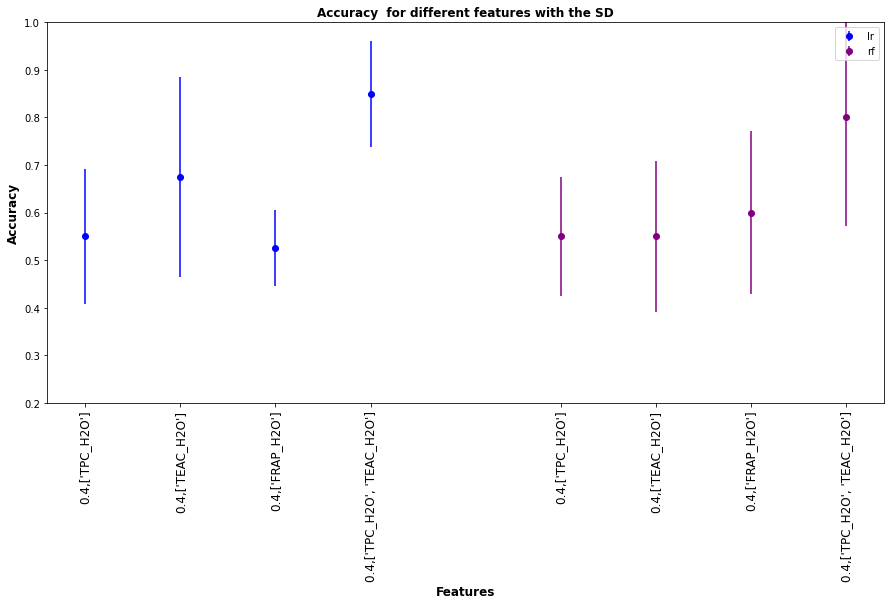

In [36]:
colors = ['blue', 'purple', 'green', 'orange', 'red', 'brown']
plt.figure(figsize=(15, 7))
plt.title( "Accuracy  for different features with the SD", fontweight ='bold', fontsize =12)
plt.xlabel("Features", fontweight ='bold', fontsize =12)
plt.ylabel("Accuracy", fontweight ='bold', fontsize =12)

count = 0
n = 5

space = []
tickFeat = []

for result, model, color in zip(arr_all, models, colors):
    a = np.linspace(n*count, n*(1+count)-2,len(features)) # to get index on the x-axis
    space.extend(a)
    tickFeat.extend(result[0])
    plt.errorbar( a, result[1], result[2], fmt='o', label =model[1], color = color)
    count += 1

plt.xticks(space, tickFeat, rotation = 'vertical',  fontsize =12)
plt.ylim(.2, 1)
plt.legend()

plt.show()

From the graph, it appears that LR possibly has a slight advantage over RF.  The accuracies seem to be slightly higher, and the error bars a bit smaller. However, none of the differences are statistically significant, because error bars overlap.
The only statistically significant result from the experiment is that the LR classifier based on two features is more accurate than those based on TPC_H20 and FRAP_H2O for LR and TPC_H2O for RF.  We can draw this conclusion because the error bars do not overlap.

### Displaying performance relative to the baseline

Do these classifiers really give us an advantage over a very simple statistical classifier that is based on Mahalanobis distance? We choose as our baseline the best Mahalanobis classifier that we found in the previous tutorial, and we plot the accuracy difference between our ML classifers and this baseline (with error bars).

First we create a list of relative accuracies and standard deviations for the different ML classifiers

In [42]:
# List containing data for different classifiers
arr_diff_all = []

# Loop through models to complie all data
for m, m_key in zip (models, ml_dicts.keys()):
    acc_diff_arr = [] 
    sd_diff_arr = [] 
    for f_key in ml_dicts[m_key].keys():
        
        
        acc_diff_arr.append( ml_dicts[m_key][f_key][ 'tot_acc' ] -  base_dict["0.4,['TPC_H2O', 'TEAC_H2O']"][ 'tot_acc' ]  )

        sd_train = jack_SD( base_dict["0.4,['TPC_H2O', 'TEAC_H2O']"][ 'jack_train' ],  ml_dicts[m_key][f_key]['jack_train'] )[0]
        sd_test = jack_SD(  base_dict["0.4,['TPC_H2O', 'TEAC_H2O']"][ 'jack_test' ] ,  ml_dicts[m_key][f_key]['jack_test']   )[0]

        sd = np.sqrt( np.array((sd_train**2)) + np.array((sd_test**2)))
        sd_diff_arr.append(sd) # append sd_arr to an array
    arr_diff_all.append([ list(ml_dicts[m_key].keys()), acc_diff_arr, sd_diff_arr])  

The information is stored in a list that tells the train/test split and features; mean accuracy difference; and standard deviation of accuracy for the baseline and ML classifiers. 

In [43]:
print(arr_diff_all)

[[["0.4,['TPC_H2O']", "0.4,['TEAC_H2O']", "0.4,['FRAP_H2O']", "0.4,['TPC_H2O', 'TEAC_H2O']"], [-0.29999999999999993, -0.17499999999999993, -0.32499999999999996, 0.0], [0.14279845632226643, 0.22032600480479742, 0.09731985329907696, 0.09565470004607042]], [["0.4,['TPC_H2O']", "0.4,['TEAC_H2O']", "0.4,['FRAP_H2O']", "0.4,['TPC_H2O', 'TEAC_H2O']"], [-0.29999999999999993, -0.29999999999999993, -0.25, -0.04999999999999993], [0.1457436634416651, 0.17151121788738863, 0.17452263578380556, 0.22960710705567428]]]


Since the results are arranged in an orderly fashion, we can now graph them. Since we are measuring relative to the baseline, the baseline appears as a solid black line at 0.
@@@ The baseline also has error bars. These should appear as dotted black lines above and below

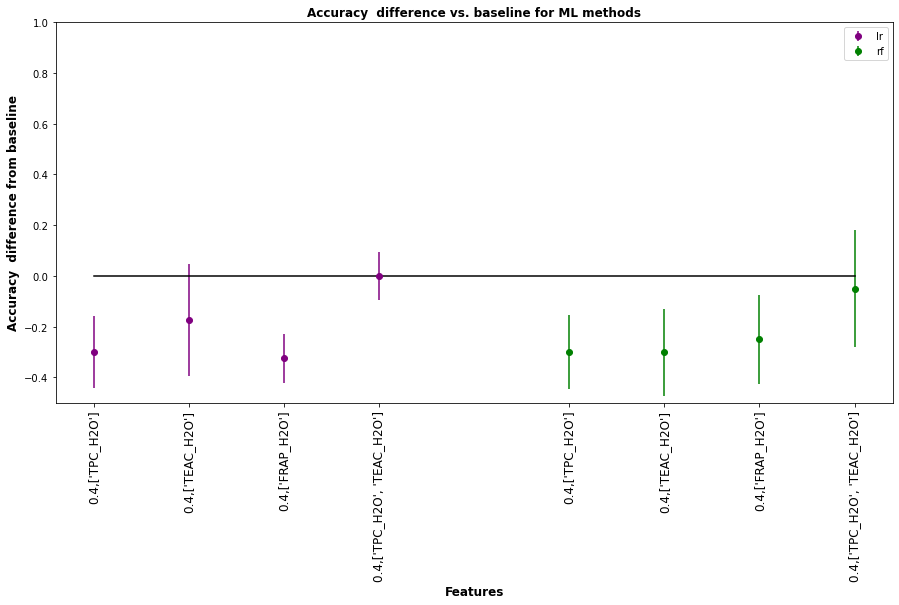

In [45]:
# colors = ['purple', 'green', 'orange', 'red', 'brown']
colors = ['purple', 'green'] # colors for the different methods
plt.figure(figsize=(15, 7))
plt.title( "Accuracy  difference vs. baseline for ML methods", fontweight ='bold', fontsize =12)
plt.xlabel("Features", fontweight ='bold', fontsize =12)
plt.ylabel("Accuracy  difference from baseline", fontweight ='bold', fontsize =12)
count = 0
n = 5
space = [] # will be used to label the x-axis
tickFeat = [] # will be used to label the x-axis

for result, model, color in zip(arr_diff_all, models, colors):
    a = np.linspace(n*count, n*(1+count)-2,len(features))
    space.extend(a)
    tickFeat.extend(result[0])
    plt.errorbar( a, result[1], result[2], fmt='o', label =model[1], color = color)
    count += 1
    
plt.plot(np.array(space), np.zeros(len(features)*len(models)), color = 'Black')        
plt.xticks(space, tickFeat, rotation = 'vertical',  fontsize =12)
plt.ylim(-.5, 1)
plt.legend()
plt.show()

The graph shows that in this case, neither LR no RF gives any statistically significant advantage over the baseline method.

### Now it's your turn
 1. Try all 3 features [TP, FRAP, TEAC] on water extracts for both LR and RF.
 2. Try other ML methods! See if you can find one that performs better (I bet you can't!)
 2. Repeat all tests using methanol instead of water.
 3. Make a comparison between water and methanol extracts.

### _The END_


<img src="pics/hap.jpg" width="300" height="200">
